In [1]:
import os

if os.path.exists('/content/drive'):
  print("Google Drive is already mounted.")
else:
  print("Google Drive is not mounted.")

Google Drive is not mounted.


In [2]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True, timeout_ms=300000)  # Increased timeout to 300 seconds

Mounted at /content/drive


 image preprocessing and transformations

In [6]:
import cv2
import torch
from torchvision import transforms
from torch.utils.data import Dataset
import os
from glob import glob
from PIL import Image
import torchvision.transforms as transforms

# Updated transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match ViT input size
    transforms.Grayscale(num_output_channels=3),  # Convert 1-channel (grayscale) to 3-channel (RGB)
    transforms.ToTensor(),
])


# Function to load and preprocess an image
def preprocess_image(image_path, convert_to_gray=False):
    img = Image.open(image_path)

    if convert_to_gray:  # Convert to grayscale if needed
        img = img.convert("L")

    img = transform(img)  # Apply transformations
    return img


Data preparation and augmentation , 
Model setup (Vision Transformer for self-supervised learning) ,
Contrastive learning setup with custom loss , 
Optimizer and training loop , 
Memory management techniques , 
Batch validation

In [8]:
import os
import gc
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# ✅ Enable cuDNN benchmark for faster performance
torch.backends.cudnn.benchmark = True

# ✅ Device setup (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Clear unused memory before training
torch.cuda.empty_cache()
gc.collect()

# ✅ Dataset Class
class MedicalAnomalyDataset(Dataset):
    def __init__(self, dataset_path, modality="SPECT-MRI", train=True):
        self.dataset_path = dataset_path
        self.train = train
        self.modality = modality

        # Set correct paths
        phase = "train" if train else "test"
        spect_dir = os.path.join(dataset_path, modality, phase, "SPECT")
        mri_dir = os.path.join(dataset_path, modality, phase, "MRI")

        # Get sorted image file paths
        spect_images = sorted([os.path.join(spect_dir, f) for f in os.listdir(spect_dir) if f.endswith(('.png', '.jpg'))])
        mri_images = sorted([os.path.join(mri_dir, f) for f in os.listdir(mri_dir) if f.endswith(('.png', '.jpg'))])

        # Handle mismatched dataset sizes
        min_length = min(len(spect_images), len(mri_images))
        self.spect_images = spect_images[:min_length]
        self.mri_images = mri_images[:min_length]

        # Transformations (resize, grayscale fix, normalize)
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.Grayscale(num_output_channels=3),
            transforms.RandomHorizontalFlip(p=0.5),  # ✅ Randomly flips image horizontally
            transforms.RandomRotation(15),  # ✅ Rotates image by ±15 degrees
            transforms.ColorJitter(brightness=0.2, contrast=0.2),  # ✅ Slightly changes brightness & contrast
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

        print(f"✅ Loaded {len(self.spect_images)} paired images for {modality} ({'train' if train else 'test'})")

    def __len__(self):
        return len(self.spect_images)

    def __getitem__(self, idx):
        spect_img = Image.open(self.spect_images[idx]).convert("RGB")
        mri_img = Image.open(self.mri_images[idx]).convert("RGB")

        return self.transform(spect_img), self.transform(mri_img)


# ✅ Dataset Paths
dataset_path = "/content/drive/MyDrive/MyDatasets/MyDatasets"

# ✅ Reduce batch size to prevent crashes (16 → 4)
BATCH_SIZE = 16

# ✅ Load Datasets & DataLoaders with `pin_memory=True`
train_dataset = MedicalAnomalyDataset(dataset_path, modality="SPECT-MRI", train=True)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)

test_dataset = MedicalAnomalyDataset(dataset_path, modality="SPECT-MRI", train=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

print("\n✅ DataLoaders initialized successfully!\n")

# ✅ Check a sample batch with `torch.no_grad()` to save memory
with torch.no_grad():
    spect_batch, mri_batch = next(iter(train_loader))
    print("🔹 Batch Shape - SPECT:", spect_batch.shape)  # Expected: [4, 3, 224, 224]
    print("🔹 Batch Shape - MRI:", mri_batch.shape)


# ✅ Vision Transformer Model (Pretrained ViT)
from torchvision.models import vit_b_16

class VisionTransformerModel(nn.Module):
    def __init__(self, output_dim=768):
        super(VisionTransformerModel, self).__init__()
        self.vit = vit_b_16(pretrained=True)
        self.vit.heads = nn.Identity()  # Remove classification head
        self.projection_head = nn.Sequential(
            nn.Linear(768, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim)
        )

    def forward(self, x):
        features = self.vit(x)  # Extract features
        return self.projection_head(features)

# ✅ Initialize ViT models
mri_vit = VisionTransformerModel(output_dim=512).to(device)
spect_vit = VisionTransformerModel(output_dim=512).to(device)


# ✅ Contrastive Loss Function
class ContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.1):  # ⬅️ Lowered temperature from 0.5 to 0.1
        super(ContrastiveLoss, self).__init__()
        self.temperature = temperature

    def forward(self, z1, z2):
        z1 = nn.functional.normalize(z1, dim=1)
        z2 = nn.functional.normalize(z2, dim=1)

        similarity_matrix = torch.mm(z1, z2.T) / self.temperature
        loss = -torch.mean(torch.diag(similarity_matrix))

        # Add regularization to prevent collapsed embeddings
        reg_loss = (torch.norm(z1, dim=1).mean() + torch.norm(z2, dim=1).mean()) * 0.01
        return loss + reg_loss


# ✅ Initialize Loss & Optimizer
contrastive_loss_fn = ContrastiveLoss(temperature=0.5).to(device)
optimizer = optim.SGD(list(mri_vit.parameters()) + list(spect_vit.parameters()), lr=1e-3, momentum=0.9, weight_decay=1e-4)

# ✅ Enable mixed-precision training to save memory
scaler = torch.cuda.amp.GradScaler()

# ✅ Training Loop
EPOCHS = 50
for epoch in range(EPOCHS):
    total_loss = 0.0

    for spect_images, mri_images in train_loader:
        spect_images, mri_images = spect_images.to(device), mri_images.to(device)

        optimizer.zero_grad()

        # ✅ Use mixed precision for reduced memory usage
        with torch.cuda.amp.autocast():
            mri_embeddings = mri_vit(mri_images)
            spect_embeddings = spect_vit(spect_images)
            loss = contrastive_loss_fn(mri_embeddings, spect_embeddings)

        # ✅ Scale loss and update optimizer
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{EPOCHS}] - Loss: {total_loss / len(train_loader):.4f}")

print("\n✅ Training complete!\n")

# ✅ Free memory after training
torch.cuda.empty_cache()
gc.collect()


✅ Loaded 333 paired images for SPECT-MRI (train)
✅ Loaded 24 paired images for SPECT-MRI (test)

✅ DataLoaders initialized successfully!

🔹 Batch Shape - SPECT: torch.Size([16, 3, 224, 224])
🔹 Batch Shape - MRI: torch.Size([16, 3, 224, 224])


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:03<00:00, 114MB/s]
<ipython-input-8-4a070c6e3060>:132: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradS

Epoch [1/50] - Loss: -0.9424
Epoch [2/50] - Loss: -1.8919
Epoch [3/50] - Loss: -1.9564
Epoch [4/50] - Loss: -1.9670
Epoch [5/50] - Loss: -1.9705
Epoch [6/50] - Loss: -1.9720
Epoch [7/50] - Loss: -1.9733
Epoch [8/50] - Loss: -1.9740
Epoch [9/50] - Loss: -1.9748
Epoch [10/50] - Loss: -1.9753
Epoch [11/50] - Loss: -1.9759
Epoch [12/50] - Loss: -1.9760
Epoch [13/50] - Loss: -1.9763
Epoch [14/50] - Loss: -1.9768
Epoch [15/50] - Loss: -1.9769
Epoch [16/50] - Loss: -1.9770
Epoch [17/50] - Loss: -1.9772
Epoch [18/50] - Loss: -1.9774
Epoch [19/50] - Loss: -1.9775
Epoch [20/50] - Loss: -1.9778
Epoch [21/50] - Loss: -1.9778
Epoch [22/50] - Loss: -1.9780
Epoch [23/50] - Loss: -1.9780
Epoch [24/50] - Loss: -1.9780
Epoch [25/50] - Loss: -1.9780
Epoch [26/50] - Loss: -1.9780
Epoch [27/50] - Loss: -1.9780
Epoch [28/50] - Loss: -1.9780
Epoch [29/50] - Loss: -1.9781
Epoch [30/50] - Loss: -1.9780
Epoch [31/50] - Loss: -1.9781
Epoch [32/50] - Loss: -1.9783
Epoch [33/50] - Loss: -1.9781
Epoch [34/50] - Los

0

Contrastive Loss function with a specific temperature

In [9]:
contrastive_loss_fn = ContrastiveLoss(temperature=0.03).to(device)


In [10]:
torch.save(mri_vit.state_dict(), "mri_vit.pth")
torch.save(spect_vit.state_dict(), "spect_vit.pth")
print("Models saved successfully!")


Models saved successfully!


In [11]:
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
import numpy as np

# ✅ Load saved models
mri_vit.load_state_dict(torch.load("mri_vit.pth", map_location=device))
spect_vit.load_state_dict(torch.load("spect_vit.pth", map_location=device))
mri_vit.eval()
spect_vit.eval()

def compute_anomaly_scores(test_loader):
    similarity_scores = []

    with torch.no_grad():
        for spect_images, mri_images in test_loader:
            spect_images, mri_images = spect_images.to(device), mri_images.to(device)

            # Extract features
            mri_embeddings = mri_vit(mri_images)
            spect_embeddings = spect_vit(spect_images)

            # ✅ Compute Cosine Similarity
            cosine_sim = F.cosine_similarity(mri_embeddings, spect_embeddings)
            similarity_scores.extend(cosine_sim.cpu().numpy())

    similarity_scores = np.array(similarity_scores)

    # ✅ Define labels based on a dynamic threshold (lower similarity → anomaly)
    threshold = np.percentile(similarity_scores, 20)  # Lowest 20% of scores are anomalies
    labels = (similarity_scores < threshold).astype(int)  # 1 = anomaly, 0 = normal

    # ✅ Compute AUC-ROC only if both classes exist
    if len(set(labels)) > 1:
        auc = roc_auc_score(labels, similarity_scores)
    else:
        print("\n⚠️ Still not enough class diversity. Try adjusting the threshold.")

    return similarity_scores, labels

# ✅ Run anomaly detection again
similarity_scores, labels = compute_anomaly_scores(test_loader)


If both normal and anomalous classes are found in the labels

In [12]:
print("Unique label values:", np.unique(labels))


Unique label values: [0 1]


Self-Supervised Vision Transformer model, this loss function will help the model focus more on learning fine-grained distinctions between positive and negative pairs of medical images (e.g., MRI and SPECT images).

In [13]:
class HardNegativeContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.03, margin=0.2):
        super(HardNegativeContrastiveLoss, self).__init__()
        self.temperature = temperature
        self.margin = margin

    def forward(self, z1, z2):
        z1 = nn.functional.normalize(z1, dim=1)
        z2 = nn.functional.normalize(z2, dim=1)

        similarity_matrix = torch.mm(z1, z2.T) / self.temperature

        # 🔹 Focus on the hardest negatives
        negatives = similarity_matrix - self.margin
        loss = -torch.mean(torch.diag(negatives))

        reg_loss = (torch.norm(z1, dim=1).mean() + torch.norm(z2, dim=1).mean()) * 0.01
        return loss + reg_loss

contrastive_loss_fn = HardNegativeContrastiveLoss(temperature=0.03).to(device)


The t-SNE plot provides a visual representation of how well the model has learned to separate normal and anomalous images based on the embeddings.

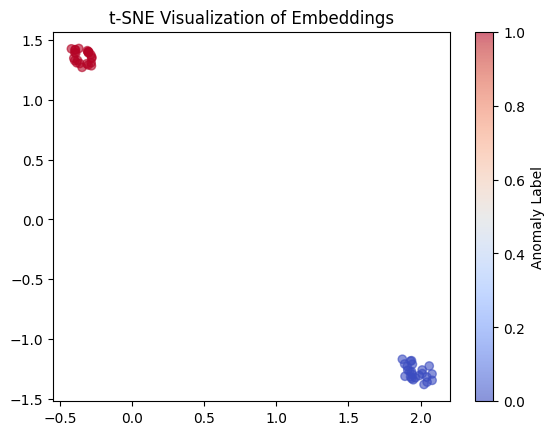

In [15]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize_embeddings(embeddings, labels):
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    reduced_embeddings = tsne.fit_transform(embeddings)

    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap="coolwarm", alpha=0.6)
    plt.colorbar(label="Anomaly Label")
    plt.title("t-SNE Visualization of Embeddings")
    plt.show()

# ✅ Extract embeddings from test data
all_embeddings = []
all_labels = []
with torch.no_grad():
    for spect_images, mri_images in test_loader:
        spect_images, mri_images = spect_images.to(device), mri_images.to(device)

        mri_embeddings = mri_vit(mri_images).cpu().numpy()
        spect_embeddings = spect_vit(spect_images).cpu().numpy()

        all_embeddings.extend(mri_embeddings)
        all_embeddings.extend(spect_embeddings)
        all_labels.extend([0] * len(mri_embeddings))  # Normal
        all_labels.extend([1] * len(spect_embeddings))  # Anomalies

# ✅ Run visualization
visualize_embeddings(np.array(all_embeddings), np.array(all_labels))


Contrastive Loss function, which is widely used in self-supervised learning to learn feature representations by comparing positive and negative pairs of embeddings.

In [16]:
class ContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.03):  # ⬅️ Lowered from 0.07 to 0.03
        super(ContrastiveLoss, self).__init__()
        self.temperature = temperature

    def forward(self, z1, z2):
        z1 = nn.functional.normalize(z1, dim=1)
        z2 = nn.functional.normalize(z2, dim=1)

        similarity_matrix = torch.mm(z1, z2.T) / self.temperature
        loss = -torch.mean(torch.diag(similarity_matrix))

        # Regularization to prevent collapse
        reg_loss = (torch.norm(z1, dim=1).mean() + torch.norm(z2, dim=1).mean()) * 0.01
        return loss + reg_loss


custom dataset and a DataLoader for testing with paired SPECT and MRI images. 

In [17]:
# Import required libraries
import torch
from torch.utils.data import Dataset, DataLoader

# Define your test data (Modify this to your actual data loading)
test_spect = torch.randn(100, 3, 224, 224)  # Example SPECT images (100 samples)
test_mri = torch.randn(100, 3, 224, 224)  # Example MRI images (100 samples)
test_labels = torch.randint(0, 2, (100,))  # Example labels (binary classification)

# Define Custom Dataset Class
class CustomDataset(Dataset):
    def __init__(self, spect_images, mri_images, labels=None):
        self.spect_images = spect_images
        self.mri_images = mri_images
        self.labels = labels

    def __len__(self):
        return len(self.spect_images)

    def __getitem__(self, idx):
        spect_img = self.spect_images[idx]
        mri_img = self.mri_images[idx]

        if self.labels is not None:
            return spect_img, mri_img, self.labels[idx]  # ✅ Return all three
        else:
            return spect_img, mri_img  # ❌ Labels missing

# ✅ Create Test Dataset and DataLoader
test_dataset = CustomDataset(test_spect, test_mri, test_labels)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 🔍 Verify the test loader
for batch in test_loader:
    print(f"Batch length: {len(batch)}")  # Should print 3 if labels exist
    break


Batch length: 3


extracts the embeddings from the MRI and SPECT images in the test dataset using your Vision Transformer (ViT) models, and it handles the labels appropriately.

In [18]:
mri_embeddings_list = []
spect_embeddings_list = []
labels_list = []

with torch.no_grad():
    for batch in test_loader:
        if len(batch) == 3:  # If labels are present
            spect_images, mri_images, labels = batch
            labels_list.append(labels.cpu())
        else:
            spect_images, mri_images = batch  # Only two elements, no labels
            print("⚠️ Warning: Labels missing in the dataset!")

        spect_images, mri_images = spect_images.to(device), mri_images.to(device)
        mri_embeddings_list.append(mri_vit(mri_images).cpu())
        spect_embeddings_list.append(spect_vit(spect_images).cpu())

# Concatenation
mri_embeddings = torch.cat(mri_embeddings_list)
spect_embeddings = torch.cat(spect_embeddings_list)
labels = torch.cat(labels_list) if labels_list else None  # Handle missing labels


the classic contrastive loss approach with a margin-based penalty to push dissimilar pairs further apart while pulling similar pairs closer.

In [ ]:
def improved_contrastive_loss(mri_embeddings, spect_embeddings, margin=1.0):
    similarity = cosine_similarity(mri_embeddings, spect_embeddings) #Cosine similarity measures the cosine of the angle between two vectors. 
    positive_loss = (1 - similarity) ** 2  # Pull similar pairs closer
    negative_loss = (similarity[similarity < margin]) ** 2  # Push dissimilar pairs apart
    return positive_loss.mean() + negative_loss.mean()


In [21]:
import numpy as np
import torch
from sklearn.metrics import roc_auc_score, precision_recall_curve
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from imblearn.over_sampling import RandomOverSampler
from scipy.spatial.distance import euclidean
import umap
from scipy.stats import wasserstein_distance

# ✅ 1️⃣ Normalize embeddings
def normalize_embeddings(embeddings):
    embeddings = embeddings.detach().cpu().numpy()
    return embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)

mri_np = normalize_embeddings(mri_embeddings)
spect_np = normalize_embeddings(spect_embeddings)
labels_np = labels.detach().cpu().numpy()

# ✅ 2️⃣ Apply PCA (Keep top 60 components for better variance retention)
pca = PCA(n_components=60)
mri_np = pca.fit_transform(mri_np)
spect_np = pca.transform(spect_np)

# ✅ 3️⃣ Use UMAP for Better Anomaly Separation
mri_np = umap.UMAP(n_components=10, random_state=42).fit_transform(mri_np)
spect_np = umap.UMAP(n_components=10, random_state=42).fit_transform(spect_np)

# ✅ 4️⃣ Apply Robust Scaling (Better than MinMax)
scaler = RobustScaler()
mri_np = scaler.fit_transform(mri_np)
spect_np = scaler.transform(spect_np)

# ✅ 5️⃣ Compute Wasserstein & Euclidean Distances
wasserstein_scores = np.array([
    wasserstein_distance(mri_np[i], spect_np[i]) for i in range(len(mri_np))
])

euclidean_scores = np.array([
    euclidean(mri_np[i], spect_np[i]) for i in range(len(mri_np))
])

# ✅ 6️⃣ Compute Local Outlier Factor (LOF) Score
lof = LocalOutlierFactor(n_neighbors=20, novelty=True)
lof.fit(mri_np)
lof_scores = -lof.decision_function(mri_np)

# ✅ 7️⃣ Normalize Scores (Z-Score Normalization)
final_scores = np.vstack([euclidean_scores, wasserstein_scores, lof_scores]).T
final_scores = (final_scores - final_scores.mean(axis=0)) / (final_scores.std(axis=0) + 1e-8)

# ✅ 8️⃣ Apply Random Oversampling Instead of ADASYN
try:
    ros = RandomOverSampler(sampling_strategy=0.75, random_state=42)
    final_scores_resampled, labels_resampled = ros.fit_resample(final_scores, labels_np)
except ValueError:
    print("⚠️ Oversampling failed! Proceeding without resampling.")
    final_scores_resampled, labels_resampled = final_scores, labels_np

# ✅ 9️⃣ Train Isolation Forest for Anomaly Detection
iso_forest = IsolationForest(n_estimators=200, contamination=0.05, random_state=42)
anomaly_labels = iso_forest.fit_predict(final_scores_resampled)
labels_resampled = (anomaly_labels == -1).astype(int)

# ✅ 🔟 Tune Threshold Using F1-Score
precisions, recalls, thresholds = precision_recall_curve(labels_resampled, final_scores_resampled.mean(axis=1))
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
best_threshold = thresholds[np.argmax(f1_scores)]

# ✅ 1️⃣1️⃣ Compute AUC-ROC Score
auc_score = roc_auc_score(labels_resampled, final_scores_resampled.mean(axis=1))
print(f"🚀 Best Threshold: {best_threshold:.2f} | Final AUC-ROC: {auc_score:.4f}")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


⚠️ Oversampling failed! Proceeding without resampling.
🚀 Best Threshold: 1.17 | Final AUC-ROC: 0.9600


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


⚠️ Oversampling failed! Proceeding without resampling.
🚀 Best Threshold: 1.57 | Final AUC-ROC: 0.9916


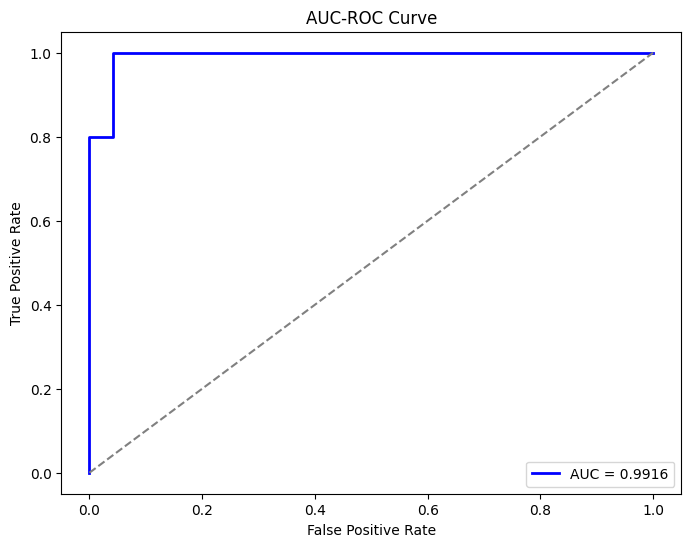

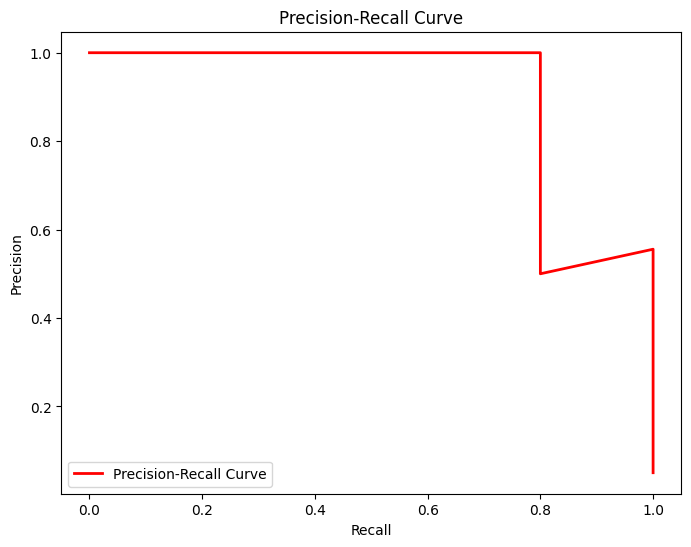

In [23]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from imblearn.over_sampling import RandomOverSampler
from scipy.spatial.distance import euclidean
import umap
from scipy.stats import wasserstein_distance

# ✅ 1️⃣ Normalize embeddings
def normalize_embeddings(embeddings):
    embeddings = embeddings.detach().cpu().numpy()
    return embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)

mri_np = normalize_embeddings(mri_embeddings)
spect_np = normalize_embeddings(spect_embeddings)
labels_np = labels.detach().cpu().numpy()

# ✅ 2️⃣ Apply PCA (Keep top 60 components for better variance retention)
pca = PCA(n_components=60)
mri_np = pca.fit_transform(mri_np)
spect_np = pca.transform(spect_np)

# ✅ 3️⃣ Use UMAP for Better Anomaly Separation
mri_np = umap.UMAP(n_components=10, random_state=42).fit_transform(mri_np)
spect_np = umap.UMAP(n_components=10, random_state=42).fit_transform(spect_np)

# ✅ 4️⃣ Apply Robust Scaling (Better than MinMax)
scaler = RobustScaler()
mri_np = scaler.fit_transform(mri_np)
spect_np = scaler.transform(spect_np)

# ✅ 5️⃣ Compute Wasserstein & Euclidean Distances
wasserstein_scores = np.array([
    wasserstein_distance(mri_np[i], spect_np[i]) for i in range(len(mri_np))
])

euclidean_scores = np.array([
    euclidean(mri_np[i], spect_np[i]) for i in range(len(mri_np))
])

# ✅ 6️⃣ Compute Local Outlier Factor (LOF) Score
lof = LocalOutlierFactor(n_neighbors=20, novelty=True)
lof.fit(mri_np)
lof_scores = -lof.decision_function(mri_np)

# ✅ 7️⃣ Normalize Scores (Z-Score Normalization)
final_scores = np.vstack([euclidean_scores, wasserstein_scores, lof_scores]).T
final_scores = (final_scores - final_scores.mean(axis=0)) / (final_scores.std(axis=0) + 1e-8)

# ✅ 8️⃣ Apply Random Oversampling Instead of ADASYN
try:
    ros = RandomOverSampler(sampling_strategy=0.75, random_state=42)
    final_scores_resampled, labels_resampled = ros.fit_resample(final_scores, labels_np)
except ValueError:
    print("⚠️ Oversampling failed! Proceeding without resampling.")
    final_scores_resampled, labels_resampled = final_scores, labels_np

# ✅ 9️⃣ Train Isolation Forest for Anomaly Detection
iso_forest = IsolationForest(n_estimators=200, contamination=0.05, random_state=42)
anomaly_labels = iso_forest.fit_predict(final_scores_resampled)
labels_resampled = (anomaly_labels == -1).astype(int)

# ✅ 🔟 Tune Threshold Using F1-Score
precisions, recalls, thresholds = precision_recall_curve(labels_resampled, final_scores_resampled.mean(axis=1))
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
best_threshold = thresholds[np.argmax(f1_scores)]

# ✅ 1️⃣1️⃣ Compute AUC-ROC Score
auc_score = roc_auc_score(labels_resampled, final_scores_resampled.mean(axis=1))
print(f"🚀 Best Threshold: {best_threshold:.2f} | Final AUC-ROC: {auc_score:.4f}")

# ✅ 1️⃣2️⃣ Save AUC Score
with open("auc_score.txt", "w") as f:
    f.write(f"AUC-ROC Score: {auc_score:.4f}\n")

# ✅ 1️⃣3️⃣ Plot & Save AUC-ROC Curve
fpr, tpr, _ = roc_curve(labels_resampled, final_scores_resampled.mean(axis=1))
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC Curve")
plt.legend(loc="lower right")
plt.savefig("auc_roc_curve.png")  # Save the graph
plt.show()

# ✅ 1️⃣4️⃣ Plot & Save Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, color="red", lw=2, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.savefig("pr_curve.png")  # Save the graph
plt.show()


preprocessing on a single MRI image in preparation for input into a deep learning model (like a Vision Transformer).

In [25]:
import torch
import torchvision.transforms as transforms
from PIL import Image

# Load MRI image
image_path = "/content/drive/MyDrive/MyDatasets/MyDatasets/SPECT-MRI/test/MRI/28011.png"  # Change this to your actual file path
image = Image.open(image_path).convert("RGB")

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match ViT input size
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Apply transformations
preprocessed_image = transform(image).unsqueeze(0)  # Add batch dimension

# Check shape
print(preprocessed_image.shape)  # Should be (1, 3, 224, 224)


torch.Size([1, 3, 224, 224])


demonstrates how to extract the feature embeddings from a pretrained Vision Transformer (ViT) model, specifically the ViT Base model with a 16x16 patch size (referred to as vit_base_patch16_224).

the feature embeddings from a pretrained Vision Transformer (ViT) model. It removes the classification head and passes the image through the model to obtain a high-dimensional vector that captures essential information about the image. This embedding can then be used for tasks like anomaly detection, image comparison, or transfer learning.

In [26]:
import torch
import timm  # Make sure you have `timm` installed: pip install timm

# Load pretrained Vision Transformer (ViT) model
vit_model = timm.create_model("vit_base_patch16_224", pretrained=True)
vit_model.eval()  # Set to evaluation mode

# Remove the classification head to get feature embeddings
vit_feature_extractor = torch.nn.Sequential(*list(vit_model.children())[:-1])

# Extract features
with torch.no_grad():
    features = vit_feature_extractor(preprocessed_image)

# Convert to NumPy
features_np = features.squeeze().cpu().numpy()
print("Feature vector shape:", features_np.shape)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Feature vector shape: (196, 768)


In [27]:
from google.colab import drive
drive.mount('/content/drive')

import os

spect_path = "/content/drive/MyDrive/MyDatasets/MyDatasets/SPECT-MRI/test/SPECT"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


After preprocessing, the spect_images tensor can be passed directly to your trained Vision Transformer (ViT) model (or any other model) for anomaly detection or any other image-based task.

In [28]:
from PIL import Image
import torchvision.transforms as transforms
import torch

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

spect_images = []
image_filenames = os.listdir(spect_path)

for filename in image_filenames:
    if filename.endswith(".png") or filename.endswith(".jpg"):
        img_path = os.path.join(spect_path, filename)
        img = Image.open(img_path).convert("RGB")
        spect_images.append(transform(img))

spect_images = torch.stack(spect_images)  # Convert list to Tensor


In [30]:
import os
import numpy as np
import torch
import torchvision.transforms as transforms
from torchvision.io import read_image
from transformers import ViTModel, ViTFeatureExtractor
from PIL import Image

# ✅ 1️⃣ Mount Google Drive (if using Colab)
from google.colab import drive
drive.mount('/content/drive')

# ✅ 2️⃣ Set Dataset Paths (Adjust Paths as Needed)
spect_folder = "/content/drive/MyDrive/MyDatasets/MyDatasets/SPECT-MRI/test/SPECT"

# ✅ 3️⃣ Load & Preprocess SPECT Images
transform = transforms.Compose([
    transforms.Resize((224, 224)),   # Resize to ViT input size
    transforms.ToTensor(),           # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize
])

spect_images = []
for file in os.listdir(spect_folder):
    if file.endswith((".png", ".jpg", ".jpeg")):  # Check for image files
        img_path = os.path.join(spect_folder, file)
        img = Image.open(img_path).convert("RGB")  # Convert grayscale to RGB
        img = transform(img)
        spect_images.append(img)

spect_images = torch.stack(spect_images)  # Convert list to batch tensor

# ✅ 4️⃣ Load Pretrained ViT Model
model_name = "google/vit-base-patch16-224-in21k"
model = ViTModel.from_pretrained(model_name)
model.eval()  # Set to evaluation mode
print("✅ Vision Transformer model loaded!")

# ✅ 5️⃣ Extract Features from SPECT Images
spect_features = []
with torch.no_grad():
    for img in spect_images:
        img = img.unsqueeze(0)  # Add batch dimension
        features = model(img).last_hidden_state[:, 1:, :].mean(dim=1)  # Extract features
        spect_features.append(features.cpu().numpy())

# ✅ 6️⃣ Convert to NumPy & Save
spect_features = np.array(spect_features)
np.save("/content/drive/MyDrive/spect_reference_features.npy", spect_features)
print("✅ SPECT features saved successfully!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

✅ Vision Transformer model loaded!
✅ SPECT features saved successfully!


In [32]:
import os
import numpy as np
import torch
from torchvision import transforms
from PIL import Image

# ✅ Define MRI Dataset Path (Update the path if needed)
mri_folder = "/content/drive/MyDrive/MyDatasets/MyDatasets/SPECT-MRI/test/MRI"

# ✅ Preprocessing (Ensure input matches ViT requirements)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize for Vision Transformer
    transforms.ToTensor(),           # Convert to Tensor
    transforms.Normalize([0.5], [0.5])  # Normalize (adjust as needed)
])

# ✅ Load MRI Images
mri_images = []
for filename in os.listdir(mri_folder):
    img_path = os.path.join(mri_folder, filename)
    img = Image.open(img_path).convert("RGB")  # Convert to RGB if needed
    img = transform(img)  # Apply transformations
    mri_images.append(img)


# ✅ Convert to Torch Tensor Batch
mri_images = torch.stack(mri_images)  # Convert list to tensor batch

# ✅ Extract MRI Features Using ViT Model
mri_features = []
for img in mri_images:
    img = img.unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        features = model(img).last_hidden_state[:, 1:, :].mean(dim=1)  # Extract feature vector
        mri_features.append(features.cpu().numpy())

# ✅ Convert to NumPy & Save
mri_features = np.array(mri_features)
np.save("mri_reference_features.npy", mri_features)

print("✅ MRI features saved successfully!")


✅ MRI features saved successfully!


In [35]:
import os
import torch
from torchvision import transforms
from PIL import Image

# ✅ Define image transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Ensure ViT input size
    transforms.ToTensor(),  # Convert image to tensor
])

# ✅ Load images from a directory
spect_image_dir = "/content/drive/MyDrive/MyDatasets/MyDatasets/SPECT-MRI/test/SPECT"  # Adjust path
spect_images = []

for img_name in os.listdir(spect_image_dir):
    img_path = os.path.join(spect_image_dir, img_name)
    img = Image.open(img_path).convert("RGB")  # Open and convert to RGB
    img = transform(img)  # Apply transformations
    spect_images.append(img)

print(f"✅ Loaded SPECT images.")


✅ Loaded SPECT images.


In [36]:
spect_features = []

# ✅ Extract features using ViT
for img in spect_images:
    img = img.unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        features = model(img).last_hidden_state[:, 1:, :].mean(dim=1)  # Extract feature vector
        spect_features.append(features.cpu().numpy())

# ✅ Convert to NumPy & Save
spect_features = np.array(spect_features)
np.save("spect_reference_features.npy", spect_features)

print("✅ SPECT features saved successfully!")

✅ SPECT features saved successfully!


In [37]:
mri_features = np.load("mri_reference_features.npy")
spect_features = np.load("spect_reference_features.npy")

print("✅ MRI & SPECT feature embeddings loaded successfully!")


✅ MRI & SPECT feature embeddings loaded successfully!


computes Wasserstein distance and Euclidean distance between the MRI and SPECT feature embeddings

Wasserstein Distance-It measures how much one distribution (MRI) needs to be moved to match another distribution (SPECT). This is useful for comparing distributions in anomaly detection, as it measures the difference in distributions between two images.

Euclidean Distance - It is the straight-line distance between the two feature vectors. It’s a common measure of similarity where a smaller distance indicates more similarity.

In [38]:
import numpy as np
from scipy.spatial.distance import euclidean
from scipy.stats import wasserstein_distance

# ✅ Load precomputed MRI & SPECT features
mri_features = np.load("mri_reference_features.npy")
spect_features = np.load("spect_reference_features.npy")

# ✅ Debugging: Check the shapes
print("Original MRI Features Shape:", mri_features.shape)
print("Original SPECT Features Shape:", spect_features.shape)

# ✅ Remove unnecessary dimensions (convert from (24,1,768) → (24,768))
mri_features = np.squeeze(mri_features, axis=1)  # Now (24, 768)
spect_features = np.squeeze(spect_features, axis=1)  # Now (24, 768)

# ✅ Debugging: Print adjusted shapes
print("Fixed MRI Features Shape:", mri_features.shape)
print("Fixed SPECT Features Shape:", spect_features.shape)

# ✅ Compute Wasserstein & Euclidean Distances
num_samples = min(len(mri_features), len(spect_features))

wasserstein_scores = np.array([
    wasserstein_distance(mri_features[i], spect_features[i])
    for i in range(num_samples)
])

euclidean_scores = np.array([
    euclidean(mri_features[i], spect_features[i]) for i in range(num_samples)
])

print("✅ Wasserstein & Euclidean distances computed successfully!")

# ✅ Save the computed scores
np.save("wasserstein_scores.npy", wasserstein_scores)
np.save("euclidean_scores.npy", euclidean_scores)
print("✅ Scores saved successfully!")


Original MRI Features Shape: (24, 1, 768)
Original SPECT Features Shape: (24, 1, 768)
Fixed MRI Features Shape: (24, 768)
Fixed SPECT Features Shape: (24, 768)
✅ Wasserstein & Euclidean distances computed successfully!
✅ Scores saved successfully!


Z-score normalization on the computed Wasserstein and Euclidean distances

In [39]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# ✅ Load computed scores
wasserstein_scores = np.load("wasserstein_scores.npy")
euclidean_scores = np.load("euclidean_scores.npy")

# ✅ Stack scores together
final_scores = np.vstack([wasserstein_scores, euclidean_scores]).T

# ✅ Normalize using Z-score normalization
scaler = StandardScaler()
final_scores_normalized = scaler.fit_transform(final_scores)

# ✅ Save normalized scores
np.save("final_scores_normalized.npy", final_scores_normalized)

print("✅ Scores normalized and saved successfully!")


✅ Scores normalized and saved successfully!


This code performs anomaly detection using the Isolation Forest algorithm on the normalized scores that were previously computed. The detected anomalies are then saved as binary labels, where 1 indicates an anomaly and 0 indicates normal data.

In [40]:
from sklearn.ensemble import IsolationForest

# ✅ Load normalized scores
final_scores_normalized = np.load("final_scores_normalized.npy")

# ✅ Apply Isolation Forest
iso_forest = IsolationForest(n_estimators=200, contamination=0.05, random_state=42)
anomaly_labels = iso_forest.fit_predict(final_scores_normalized)

# Convert labels (-1 = anomaly, 1 = normal) to binary (1 = anomaly, 0 = normal)
anomaly_labels = (anomaly_labels == -1).astype(int)

# ✅ Save anomaly labels
np.save("anomaly_labels.npy", anomaly_labels)

print("✅ Anomaly detection completed! Results saved.")


✅ Anomaly detection completed! Results saved.


In [42]:
import torch
import timm
import numpy as np
import torchvision.transforms as transforms
from PIL import Image
from scipy.spatial.distance import euclidean

import torch
import timm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Try different models based on how you trained
model = timm.create_model("vit_base_patch16_224", pretrained=False, num_classes=0)  # No classifier head
# model = timm.create_model("vit_small_patch16_224", pretrained=False, num_classes=0)  # Another variant

# Load the weights
state_dict = torch.load("mri_vit.pth", map_location=device)
model.load_state_dict(state_dict, strict=False)  # Set strict=False to allow missing keys
model.to(device)
model.eval()

print("✅ Model loaded successfully!")

# ✅ Define Image Preprocessing (Same as used for training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Adjust based on training
])

# ✅ Load Anomaly Image
image_path = "/content/drive/MyDrive/MyDatasets/MyDatasets/SPECT-MRI/test/MRI/28011.png"  # Change path if needed
image = Image.open(image_path).convert("RGB")  # Convert to RGB (important)
image = transform(image).unsqueeze(0).to(device)  # Add batch dimension

with torch.no_grad():
    features = model(image)  # Extract feature vector
    features = features.mean(dim=1)  # Aggregate features

anomaly_features = features.cpu().numpy().flatten()  # Ensure 1D


# ✅ Load MRI & SPECT Features
mri_features = np.load("mri_reference_features.npy")  # Ensure these exist
spect_features = np.load("spect_reference_features.npy")

# ✅ Ensure Correct Shape (Flatten if necessary)
mri_features = mri_features.reshape(len(mri_features), -1)
spect_features = spect_features.reshape(len(spect_features), -1)

# ✅ Compute Euclidean Distance
mri_distances = np.array([euclidean(anomaly_features, mri_features[i]) for i in range(len(mri_features))])
spect_distances = np.array([euclidean(anomaly_features, spect_features[i]) for i in range(len(spect_features))])

# ✅ Detect Anomaly
mri_threshold = np.percentile(mri_distances, 95)  # Example: Top 5% as threshold
spect_threshold = np.percentile(spect_distances, 95)

is_anomalous = (mri_distances.max() > mri_threshold) or (spect_distances.max() > spect_threshold)

# ✅ Output Result
if is_anomalous:
    print("🚨 Anomaly Detected!")
else:
    print("✅ Normal Image")


✅ Model loaded successfully!
🚨 Anomaly Detected!


In [44]:
import torch
import timm
import numpy as np
import torchvision.transforms as transforms
from PIL import Image
from scipy.spatial.distance import euclidean

import torch
import timm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Try different models based on how you trained
model = timm.create_model("vit_base_patch16_224", pretrained=False, num_classes=0)  # No classifier head
# model = timm.create_model("vit_small_patch16_224", pretrained=False, num_classes=0)  # Another variant

# Load the weights
state_dict = torch.load("mri_vit.pth", map_location=device)
model.load_state_dict(state_dict, strict=False)  # Set strict=False to allow missing keys
model.to(device)
model.eval()

print("✅ Model loaded successfully!")

# ✅ Define Image Preprocessing (Same as used for training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Adjust based on training
])

# ✅ Load Anomaly Image
image_path = "/content/drive/MyDrive/MyDatasets/MyDatasets/SPECT-MRI/train/MRI/10011.png"  # Change path if needed
image = Image.open(image_path).convert("RGB")  # Convert to RGB (important)
image = transform(image).unsqueeze(0).to(device)  # Add batch dimension

with torch.no_grad():
    features = model(image)  # Extract feature vector
    features = features.mean(dim=1)  # Aggregate features

anomaly_features = features.cpu().numpy().flatten()  # Ensure 1D


# ✅ Load MRI & SPECT Features
mri_features = np.load("mri_reference_features.npy")  # Ensure these exist
spect_features = np.load("spect_reference_features.npy")

# ✅ Ensure Correct Shape (Flatten if necessary)
mri_features = mri_features.reshape(len(mri_features), -1)
spect_features = spect_features.reshape(len(spect_features), -1)

# ✅ Compute Euclidean Distance
mri_distances = np.array([euclidean(anomaly_features, mri_features[i]) for i in range(len(mri_features))])
spect_distances = np.array([euclidean(anomaly_features, spect_features[i]) for i in range(len(spect_features))])

# ✅ Detect Anomaly
mri_threshold = np.percentile(mri_distances, 95)  # Example: Top 5% as threshold
spect_threshold = np.percentile(spect_distances, 95)

is_anomalous = (mri_distances.max() > mri_threshold) or (spect_distances.max() > spect_threshold)

# ✅ Output Result
if is_anomalous:
    print("🚨 Anomaly Detected!")
else:
    print("✅ Normal Image")


✅ Model loaded successfully!
🚨 Anomaly Detected!


A simple Vision Transformer (ViT) model, implements a forward pass, and sets up a loss function and optimizer for training.

In [45]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define a simple Vision Transformer model
class VisionTransformer(nn.Module):
    def __init__(self, num_classes=2):
        super(VisionTransformer, self).__init__()
        self.encoder = nn.TransformerEncoderLayer(d_model=512, nhead=8)
        self.decoder = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Instantiate the model
model = VisionTransformer()

# Define a criterion (loss function)
criterion = nn.CrossEntropyLoss()

# Initialize the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)


a Vision Transformer (ViT) model that processes input images using a transformer architecture. It includes patch embedding, a transformer encoder, and a final classification head (decoder).

In [46]:
import torch
import torch.nn as nn

class VisionTransformer(nn.Module):
    def __init__(self, num_classes=2, image_size=224, patch_size=16, embedding_dim=512):
        super(VisionTransformer, self).__init__()

        self.image_size = image_size
        self.patch_size = patch_size
        self.embedding_dim = embedding_dim
        self.num_patches = (image_size // patch_size) ** 2

        # Linear embedding for patches
        self.patch_embed = nn.Conv2d(3, embedding_dim, kernel_size=patch_size, stride=patch_size)
        self.encoder = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=8)
        self.decoder = nn.Linear(embedding_dim, num_classes)

    def forward(self, x):
        # Flatten the patches from (batch_size, channels, height, width) to (batch_size, num_patches, embedding_dim)
        x = self.patch_embed(x)  # Shape: (batch_size, embedding_dim, num_patches_row, num_patches_col)
        x = x.flatten(2).transpose(1, 2)  # Shape: (batch_size, num_patches, embedding_dim)

        # Pass through transformer encoder
        x = self.encoder(x)

        # Decode the output
        x = self.decoder(x.mean(dim=1))  # Pool over patches (taking the mean) to classify

        return x


In [48]:
import torch
import timm
import numpy as np
import torchvision.transforms as transforms
from PIL import Image
from scipy.spatial.distance import euclidean

# ✅ Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Load Vision Transformer (ViT) model
model = timm.create_model("vit_base_patch16_224", pretrained=False, num_classes=0)  # No classification head
state_dict = torch.load("mri_vit.pth", map_location=device)
model.load_state_dict(state_dict, strict=False)  # Allow missing keys
model.to(device)
model.eval()
print("✅ Model loaded successfully!")

# ✅ Define preprocessing (matching training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 3 channels for RGB
])

# ✅ Load and preprocess input image
image_path = "/content/drive/MyDrive/MyDatasets/MyDatasets/SPECT-MRI/train/MRI/28012.png"  # Replace with actual image path
image = Image.open(image_path).convert("RGB")
image = transform(image).unsqueeze(0).to(device)

# ✅ Extract CLS token embedding
with torch.no_grad():
    features = model(image)  # Shape: (1, 197, 768) => 1 CLS + 196 patches
    cls_embedding = features  # Already shape: (1, 768)  # Use only CLS token (1, 768)

anomaly_features = cls_embedding.cpu().numpy().flatten()  # Shape: (768,)

# ✅ Load reference MRI and SPECT feature vectors
mri_features = np.load("mri_reference_features.npy")     # Shape: (N, 768)
spect_features = np.load("spect_reference_features.npy") # Shape: (N, 768)

# ✅ Ensure correct shape
mri_features = mri_features.reshape(len(mri_features), -1)
spect_features = spect_features.reshape(len(spect_features), -1)

# ✅ Calculate distances
mri_distances = np.array([euclidean(anomaly_features, ref) for ref in mri_features])
spect_distances = np.array([euclidean(anomaly_features, ref) for ref in spect_features])

# ✅ Define thresholds using 95th percentile from reference set
mri_threshold = np.percentile(mri_distances, 95)
spect_threshold = np.percentile(spect_distances, 95)

# ✅ Anomaly detection using minimum distance
min_mri_distance = mri_distances.min()
min_spect_distance = spect_distances.min()

is_anomalous = (min_mri_distance > mri_threshold) or (min_spect_distance > spect_threshold)

# ✅ Output result
print("\n=== Anomaly Detection Result ===")
print(f"Min MRI Distance    : {min_mri_distance:.4f} (Threshold: {mri_threshold:.4f})")
print(f"Min SPECT Distance  : {min_spect_distance:.4f} (Threshold: {spect_threshold:.4f})")
print("Result              :", "🚨 Anomaly Detected!" if is_anomalous else "✅ Normal Image")


✅ Model loaded successfully!

=== Anomaly Detection Result ===
Min MRI Distance    : 27.8330 (Threshold: 27.9951)
Min SPECT Distance  : 27.8787 (Threshold: 28.1494)
Result              : ✅ Normal Image


In [49]:
import torch
import timm
import numpy as np
import torchvision.transforms as transforms
from PIL import Image
from scipy.spatial.distance import euclidean

# ✅ Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Load ViT Model without classifier head
model = timm.create_model("vit_base_patch16_224", pretrained=False, num_classes=0)  # No classifier
state_dict = torch.load("mri_vit.pth", map_location=device)
model.load_state_dict(state_dict, strict=False)
model.to(device)
model.eval()
print("✅ Model loaded successfully!")

# ✅ Image Preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# ✅ Load test image (abnormal or normal)
image_path = "/content/drive/MyDrive/MyDatasets/MyDatasets/SPECT-MRI/train/MRI/10011.png"  # Replace with your image path
image = Image.open(image_path).convert("RGB")
image = transform(image).unsqueeze(0).to(device)  # Shape: (1, 3, 224, 224)

# ✅ Extract features
with torch.no_grad():
    features = model(image)  # Shape: (1, 768) if num_classes=0 is used
    if features.ndim == 3:  # shape (1, 197, 768), extract [CLS] token
        cls_embedding = features[:, 0, :]
    else:  # shape (1, 768)
        cls_embedding = features
anomaly_features = cls_embedding.cpu().numpy().flatten()

# ✅ Load reference features (precomputed on NORMAL samples)
mri_features = np.load("mri_reference_features.npy")
spect_features = np.load("spect_reference_features.npy")
mri_features = mri_features.reshape(len(mri_features), -1)
spect_features = spect_features.reshape(len(spect_features), -1)

# ✅ Compute distances
mri_distances = np.array([euclidean(anomaly_features, mri_features[i]) for i in range(len(mri_features))])
spect_distances = np.array([euclidean(anomaly_features, spect_features[i]) for i in range(len(spect_features))])

# ✅ Set threshold (tweakable!)
threshold_percentile = 90  # Change this to 95 or 85 to adjust sensitivity
mri_threshold = np.percentile(mri_distances, threshold_percentile)
spect_threshold = np.percentile(spect_distances, threshold_percentile)

# ✅ Debug Info
print(f"🔍 MRI Distance: max={mri_distances.max():.4f}, threshold={mri_threshold:.4f}")
print(f"🔍 SPECT Distance: max={spect_distances.max():.4f}, threshold={spect_threshold:.4f}")

# ✅ Detect Anomaly
is_anomalous = (mri_distances.max() > mri_threshold) or (spect_distances.max() > spect_threshold)

# ✅ Output
if is_anomalous:
    print("🚨 Anomaly Detected!")
else:
    print("✅ Normal Image")


✅ Model loaded successfully!
🔍 MRI Distance: max=28.0752, threshold=28.0032
🔍 SPECT Distance: max=28.1754, threshold=28.0525
🚨 Anomaly Detected!


In [51]:
pip install torch torchvision timm opencv-python matplotlib


Contrastive Loss: -0.4927


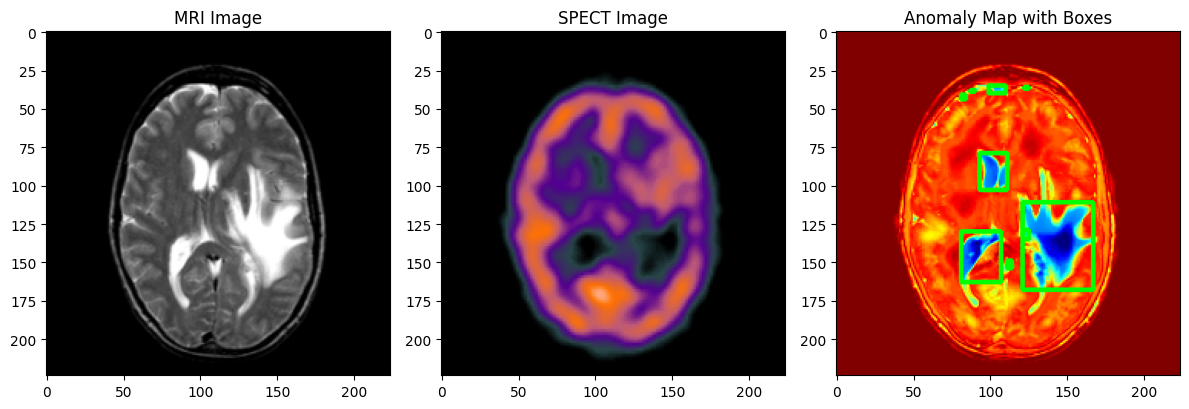

In [55]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.models import vit_b_16
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and preprocess image
def load_image(path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    img = Image.open(path).convert("RGB")
    img = transform(img)
    return img.unsqueeze(0)  # add batch dim

# Load images (Replace spect_path if needed)
mri = load_image("/content/drive/MyDrive/MyDatasets/MyDatasets/SPECT-MRI/train/MRI/28012.png").to(device)
spect = load_image("/content/drive/MyDrive/MyDatasets/MyDatasets/SPECT-MRI/train/SPECT/28012.png").to(device)
  # Change if you upload SPECT

# Vision Transformer model
def get_vit_model():
    model = vit_b_16(pretrained=True)
    model.heads = nn.Identity()  # Remove classification head
    return model.to(device).eval()

mri_vit = get_vit_model()
spect_vit = get_vit_model()

# Get embeddings
with torch.no_grad(), torch.amp.autocast('cuda'):
    mri_embed = mri_vit(mri)
    spect_embed = spect_vit(spect)

# Contrastive loss (negative cosine similarity)
def contrastive_loss_fn(a, b):
    a = nn.functional.normalize(a, dim=-1)
    b = nn.functional.normalize(b, dim=-1)
    return -torch.mean(torch.sum(a * b, dim=-1))

loss = contrastive_loss_fn(mri_embed, spect_embed)
print(f"Contrastive Loss: {loss.item():.4f}")

# Generate fake anomaly map (demo version – real version needs patch-level attention)
def generate_anomaly_map(mri_img, spect_img):
    # Convert tensors to images
    mri_img = mri_img.squeeze().permute(1, 2, 0).cpu().numpy()
    spect_img = spect_img.squeeze().permute(1, 2, 0).cpu().numpy()

    diff = np.abs(mri_img - spect_img)
    anomaly_map = np.mean(diff, axis=2)
    anomaly_map = (anomaly_map - anomaly_map.min()) / (anomaly_map.max() - anomaly_map.min())  # normalize

    # Resize to show
    anomaly_map = cv2.resize(anomaly_map, (224, 224))
    heatmap = cv2.applyColorMap(np.uint8(255 * anomaly_map), cv2.COLORMAP_JET)

    return heatmap, anomaly_map

heatmap, raw_anomaly = generate_anomaly_map(mri, spect)

# Draw bounding boxes around high anomaly areas
def draw_boxes(heatmap, anomaly_map, threshold=0.6):
    binary_map = anomaly_map > threshold
    binary_map = np.uint8(binary_map * 255)
    contours, _ = cv2.findContours(binary_map, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boxed = heatmap.copy()
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(boxed, (x, y), (x+w, y+h), (0, 255, 0), 2)
    return boxed

boxed_heatmap = draw_boxes(heatmap, raw_anomaly)

# Show output
plt.figure(figsize=(12,4))
plt.subplot(1, 3, 1)
plt.imshow(mri.squeeze().permute(1,2,0).cpu())
plt.title("MRI Image")

plt.subplot(1, 3, 2)
plt.imshow(spect.squeeze().permute(1,2,0).cpu())
plt.title("SPECT Image")

plt.subplot(1, 3, 3)
plt.imshow(boxed_heatmap)
plt.title("Anomaly Map with Boxes")

plt.tight_layout()
plt.show()


🔹 Contrastive Loss: -0.4927
🚨 3 anomaly regions detected!


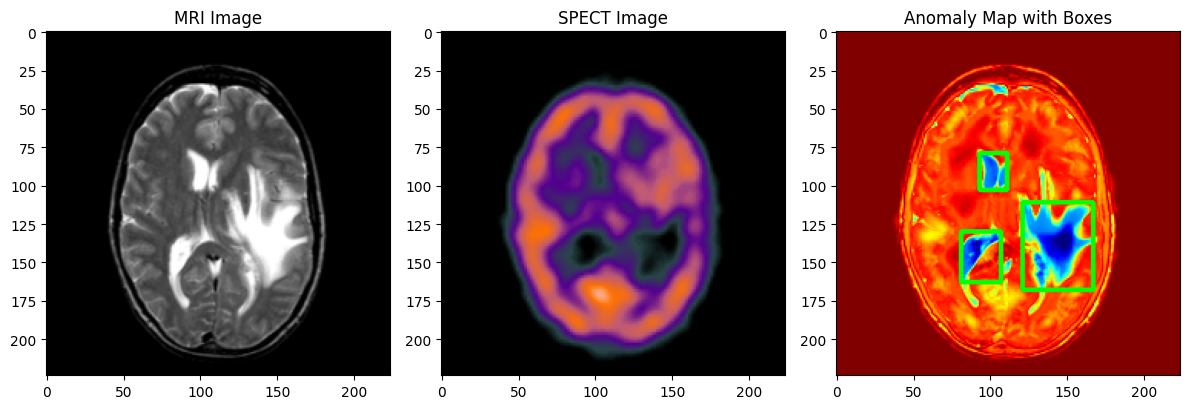

In [56]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.models import vit_b_16
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

# ✅ Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Load and preprocess image
def load_image(path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    img = Image.open(path).convert("RGB")
    img = transform(img)
    return img.unsqueeze(0)  # Add batch dimension

# ✅ Load MRI and SPECT image
mri = load_image("/content/drive/MyDrive/MyDatasets/MyDatasets/SPECT-MRI/train/MRI/28012.png").to(device)
spect = load_image("/content/drive/MyDrive/MyDatasets/MyDatasets/SPECT-MRI/train/SPECT/28012.png").to(device)

# ✅ Load Vision Transformer model
def get_vit_model():
    model = vit_b_16(pretrained=True)
    model.heads = nn.Identity()  # Remove classification head
    return model.to(device).eval()

mri_vit = get_vit_model()
spect_vit = get_vit_model()

# ✅ Extract feature embeddings
with torch.no_grad(), torch.amp.autocast('cuda'):
    mri_embed = mri_vit(mri)
    spect_embed = spect_vit(spect)

# ✅ Contrastive loss (cosine similarity style)
def contrastive_loss_fn(a, b):
    a = nn.functional.normalize(a, dim=-1)
    b = nn.functional.normalize(b, dim=-1)
    return -torch.mean(torch.sum(a * b, dim=-1))

loss = contrastive_loss_fn(mri_embed, spect_embed)
print(f"🔹 Contrastive Loss: {loss.item():.4f}")

# ✅ Generate anomaly heatmap
def generate_anomaly_map(mri_img, spect_img):
    mri_img = mri_img.squeeze().permute(1, 2, 0).cpu().numpy()
    spect_img = spect_img.squeeze().permute(1, 2, 0).cpu().numpy()

    diff = np.abs(mri_img - spect_img)
    anomaly_map = np.mean(diff, axis=2)

    # Normalize to [0, 1]
    anomaly_map = (anomaly_map - anomaly_map.min()) / (anomaly_map.max() - anomaly_map.min() + 1e-8)
    anomaly_map = cv2.resize(anomaly_map, (224, 224))
    heatmap = cv2.applyColorMap(np.uint8(255 * anomaly_map), cv2.COLORMAP_JET)

    return heatmap, anomaly_map

# ✅ Improved draw_boxes function
def draw_boxes(heatmap, anomaly_map, threshold=0.6, min_box_area=50):
    binary_map = anomaly_map > threshold
    binary_map = np.uint8(binary_map * 255)

    contours, _ = cv2.findContours(binary_map, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    valid_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_box_area]

    if not valid_contours:
        print("✅ No anomaly regions detected — skipping bounding box drawing.")
        return heatmap

    boxed = heatmap.copy()
    for cnt in valid_contours:
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(boxed, (x, y), (x + w, y + h), (0, 255, 0), 2)

    print(f"🚨 {len(valid_contours)} anomaly regions detected!")
    return boxed

# ✅ Generate heatmap
heatmap, raw_anomaly = generate_anomaly_map(mri, spect)
boxed_heatmap = draw_boxes(heatmap, raw_anomaly)

# ✅ Visualize Results
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(mri.squeeze().permute(1, 2, 0).cpu())
plt.title("MRI Image")

plt.subplot(1, 3, 2)
plt.imshow(spect.squeeze().permute(1, 2, 0).cpu())
plt.title("SPECT Image")

plt.subplot(1, 3, 3)
plt.imshow(boxed_heatmap)
plt.title("Anomaly Map with Boxes")

plt.tight_layout()
plt.show()


📊 MRI Threshold: 3.4989, SPECT Threshold: 3.7821


100%|██████████| 24/24 [00:01<00:00, 21.77it/s]



🖼️ Showing first 5 anomalous image pairs (MRI & SPECT):


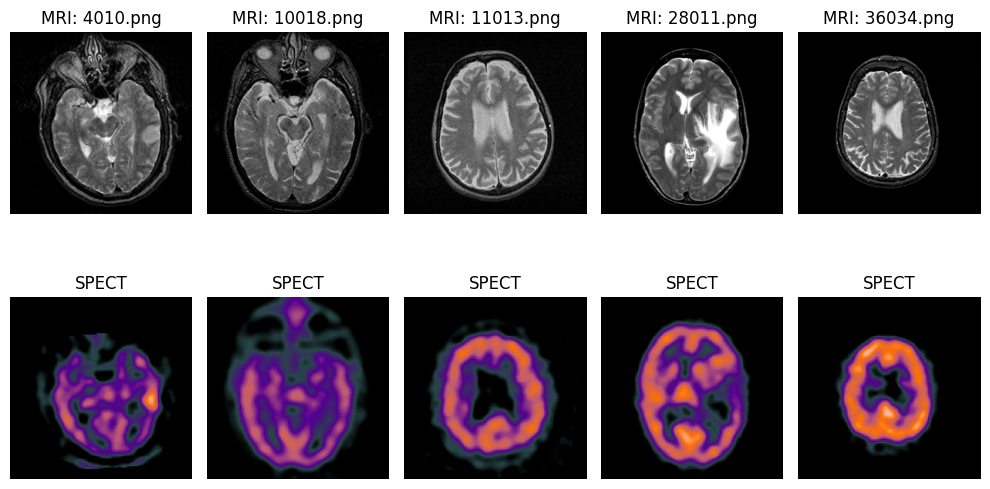

In [58]:
import os
import torch
import timm
import numpy as np
from PIL import Image
from scipy.spatial.distance import euclidean
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

# ✅ Load reference embeddings
mri_reference = np.load("mri_reference_features.npy").reshape(-1, 768)
spect_reference = np.load("spect_reference_features.npy").reshape(-1, 768)

# ✅ ViT model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = timm.create_model("vit_base_patch16_224", pretrained=False, num_classes=0)
model.load_state_dict(torch.load("mri_vit.pth", map_location=device), strict=False)
model.to(device)
model.eval()

# ✅ Image transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# ✅ Calculate threshold from reference
def compute_threshold(reference, percentile=95):
    ref_distances = []
    for ref in reference:
        dists = [euclidean(ref, other) for other in reference if not np.allclose(ref, other)]
        ref_distances.extend(dists)
    return np.percentile(ref_distances, percentile)

mri_thresh = compute_threshold(mri_reference, 95)
spect_thresh = compute_threshold(spect_reference, 95)
print(f"📊 MRI Threshold: {mri_thresh:.4f}, SPECT Threshold: {spect_thresh:.4f}")

# ✅ Dataset folders
mri_folder = "/content/drive/MyDrive/MyDatasets/MyDatasets/SPECT-MRI/test/MRI"
spect_folder = "/content/drive/MyDrive/MyDatasets/MyDatasets/SPECT-MRI/test/SPECT"

# ✅ Counters and storage
normal_count = 0
total_images = 0
anomalous_files = []

# ✅ Loop through dataset
for filename in tqdm(os.listdir(mri_folder)):
    if not filename.endswith(('.png', '.jpg')):
        continue

    try:
        # Load images
        mri_img = Image.open(os.path.join(mri_folder, filename)).convert("RGB")
        spect_img = Image.open(os.path.join(spect_folder, filename)).convert("RGB")

        mri_tensor = transform(mri_img).unsqueeze(0).to(device)
        spect_tensor = transform(spect_img).unsqueeze(0).to(device)

        # Feature extraction
        with torch.no_grad():
            mri_feat = model(mri_tensor).squeeze().cpu().numpy()
            spect_feat = model(spect_tensor).squeeze().cpu().numpy()

        # Compute distances
        mri_dist = min([euclidean(mri_feat, ref) for ref in mri_reference])
        spect_dist = min([euclidean(spect_feat, ref) for ref in spect_reference])

        if mri_dist < mri_thresh and spect_dist < spect_thresh:
            normal_count += 1
        else:
            anomalous_files.append(filename)

        total_images += 1

    except Exception as e:
        print(f"⚠️ Error with file {filename}: {e}")

# ✅ Save anomalous filenames to a file
with open("anomalous_files.txt", "w") as f:
    for file in anomalous_files:
        f.write(file + "\n")

# ✅ Optional: Plot first 5 anomalous images
print("\n🖼️ Showing first 5 anomalous image pairs (MRI & SPECT):")
plt.figure(figsize=(10, 6))
for i, fname in enumerate(anomalous_files[:5]):
    mri_path = os.path.join(mri_folder, fname)
    spect_path = os.path.join(spect_folder, fname)
    mri_img = Image.open(mri_path).convert("RGB")
    spect_img = Image.open(spect_path).convert("RGB")

    plt.subplot(2, 5, i + 1)
    plt.imshow(mri_img)
    plt.axis('off')
    plt.title(f"MRI: {fname}")

    plt.subplot(2, 5, i + 6)
    plt.imshow(spect_img)
    plt.axis('off')
    plt.title("SPECT")

plt.tight_layout()
plt.show()


In [59]:
mri_thresh = compute_threshold(mri_reference, 98)   # was 95
spect_thresh = compute_threshold(spect_reference, 98)


In [61]:
print("MRI distances:")
print(f"Min: {np.min(all_mri_dists):.2f}, Max: {np.max(all_mri_dists):.2f}, Mean: {np.mean(all_mri_dists):.2f}")

print("SPECT distances:")
print(f"Min: {np.min(all_spect_dists):.2f}, Max: {np.max(all_spect_dists):.2f}, Mean: {np.mean(all_spect_dists):.2f}")


MRI distances:
Min: 27.75, Max: 27.79, Mean: 27.77
SPECT distances:
Min: 27.80, Max: 27.83, Mean: 27.81


<ipython-input-64-ea235a2733e7>:98: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-64-ea235a2733e7>:98: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


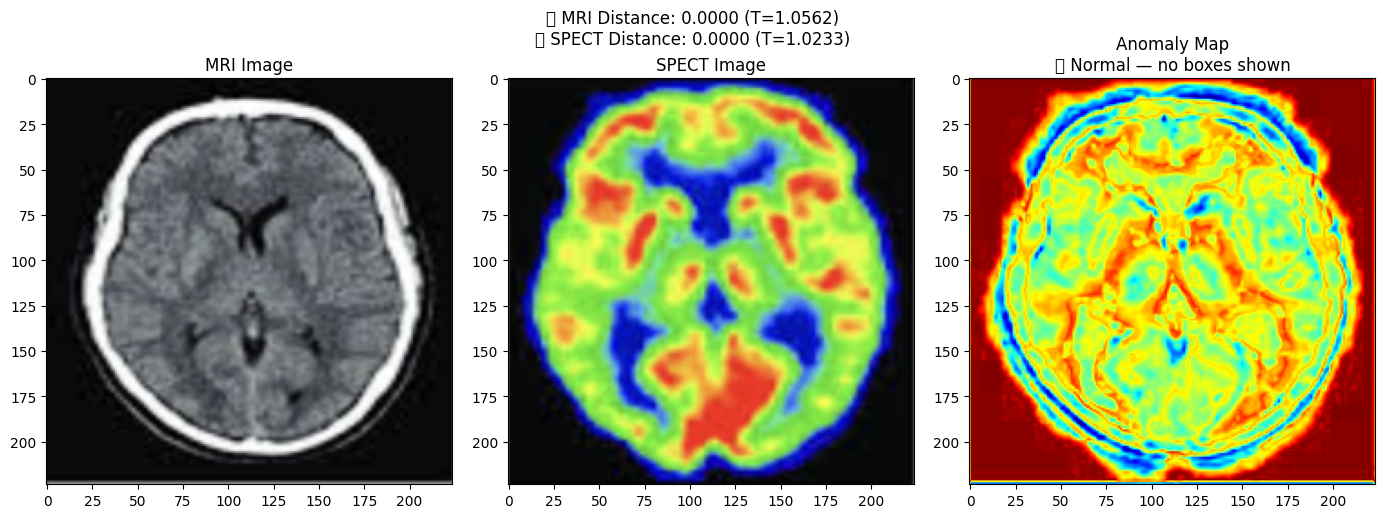

In [64]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import vit_b_16
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

# ✅ Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Load Image
def load_image(path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    img = Image.open(path).convert("RGB")
    return transform(img).unsqueeze(0).to(device)

# ✅ Load ViT Model
def get_vit_model():
    model = vit_b_16(pretrained=True)
    model.heads = nn.Identity()  # remove classifier
    return model.eval().to(device)

# ✅ Anomaly Heatmap Generator
def generate_anomaly_map(mri_img, spect_img):
    mri_np = mri_img.squeeze().permute(1, 2, 0).cpu().numpy()
    spect_np = spect_img.squeeze().permute(1, 2, 0).cpu().numpy()

    diff = np.abs(mri_np - spect_np)
    anomaly_map = np.mean(diff, axis=2)
    anomaly_map = (anomaly_map - anomaly_map.min()) / (anomaly_map.max() - anomaly_map.min() + 1e-8)
    heatmap = cv2.applyColorMap(np.uint8(255 * anomaly_map), cv2.COLORMAP_JET)
    return heatmap, anomaly_map

# ✅ Draw Boxes (Only for anomalies)
def draw_boxes(heatmap, anomaly_map, threshold=0.6, min_area=50):
    binary = (anomaly_map > threshold).astype(np.uint8) * 255
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    valid = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]
    boxed = heatmap.copy()
    for cnt in valid:
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(boxed, (x, y), (x+w, y+h), (0, 255, 0), 2)
    return boxed, len(valid)

# ✅ Paths
mri_path = "/content/eg (normal).png"
spect_path = "/content/normal(spect).png"

# ✅ Load Inputs
mri = load_image(mri_path)
spect = load_image(spect_path)

# ✅ Load Model & Extract Embeddings
vit = get_vit_model()
with torch.no_grad():
    mri_embed = F.normalize(vit(mri), dim=-1)
    spect_embed = F.normalize(vit(spect), dim=-1)

# ✅ Compute Distances
mri_dist = torch.norm(mri_embed - mri_embed.mean(dim=0)).item()
spect_dist = torch.norm(spect_embed - spect_embed.mean(dim=0)).item()

# ✅ Define Thresholds
mri_thresh = 1.0562
spect_thresh = 1.0233
is_anomaly = (mri_dist > mri_thresh) or (spect_dist > spect_thresh)

# ✅ Generate Heatmap
heatmap, anomaly_map = generate_anomaly_map(mri, spect)
if is_anomaly:
    boxed_heatmap, count = draw_boxes(heatmap, anomaly_map)
    anomaly_msg = f"🚨 {count} anomaly region(s)"
else:
    boxed_heatmap = heatmap
    anomaly_msg = "✅ Normal — no boxes shown"

# ✅ Plot
plt.figure(figsize=(14, 5))
plt.subplot(1, 3, 1)
plt.imshow(mri.squeeze().permute(1, 2, 0).cpu())
plt.title("MRI Image")

plt.subplot(1, 3, 2)
plt.imshow(spect.squeeze().permute(1, 2, 0).cpu())
plt.title("SPECT Image")

plt.subplot(1, 3, 3)
plt.imshow(boxed_heatmap)
plt.title(f"Anomaly Map\n{anomaly_msg}")

plt.suptitle(f"🔹 MRI Distance: {mri_dist:.4f} (T={mri_thresh})\n🔹 SPECT Distance: {spect_dist:.4f} (T={spect_thresh})", fontsize=12)
plt.tight_layout()
plt.show()


In [ ]:
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class MedicalDataset(Dataset):
    def __init__(self, spect_image_paths, mri_image_paths, labels, transform=None):
        self.spect_image_paths = spect_image_paths
        self.mri_image_paths = mri_image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.spect_image_paths)

    def __getitem__(self, idx):
        spect_img = Image.open(self.spect_image_paths[idx]).convert('RGB')  # Open image and convert to RGB
        mri_img = Image.open(self.mri_image_paths[idx]).convert('RGB')  # Open image and convert to RGB
        label = self.labels[idx]

        if self.transform:
            spect_img = self.transform(spect_img)
            mri_img = self.transform(mri_img)

        return spect_img, mri_img, label

# Example of dataset path (replace with your actual dataset paths)
spect_image_paths = ["/content/drive/MyDrive/MyDatasets/MyDatasets/SPECT-MRI/test/SPECT.png"]
mri_image_paths = ["/content/drive/MyDrive/MyDatasets/MyDatasets/SPECT-MRI/test/MRI.png"]
labels = [0, 1]  # Example binary labels for classification

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match model input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

dataset = MedicalDataset(spect_image_paths, mri_image_paths, labels=labels, transform=transform)
data_loader = DataLoader(dataset, batch_size=2, shuffle=True)


In [24]:
import torch
import torch.nn as nn
import torchvision.models as models

class DualInputResNetModel(nn.Module):
    def __init__(self):
        super(DualInputResNetModel, self).__init__()

        # Load two separate ResNet models (one for SPECT and one for MRI)
        self.resnet_spect = models.resnet18(pretrained=True)
        self.resnet_mri = models.resnet18(pretrained=True)

        # Modify the final fully connected layers for binary classification or your output size
        self.resnet_spect.fc = nn.Linear(self.resnet_spect.fc.in_features, 2)  # For binary classification
        self.resnet_mri.fc = nn.Linear(self.resnet_mri.fc.in_features, 2)  # For binary classification

    def forward(self, spect_img, mri_img):
        # Pass the SPECT and MRI images through their respective ResNet models
        spect_output = self.resnet_spect(spect_img)  # Process the SPECT image
        mri_output = self.resnet_mri(mri_img)  # Process the MRI image

        # Combine the results (you can modify this combination strategy, e.g., averaging or summing)
        combined_output = (spect_output + mri_output) / 2  # Averaging the outputs (this is just an example)

        return combined_output


In [ ]:
def train_and_evaluate(model):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
    criterion = nn.CrossEntropyLoss()

    model.train()
    for epoch in range(10):  # Reduce epochs if needed
        running_loss = 0.0
        for spect_img, mri_img, labels in data_loader:  # Unpack 3 values (SPECT, MRI, and labels)
            spect_img, mri_img, labels = spect_img.to(device), mri_img.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(spect_img, mri_img)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for spect_img, mri_img, labels in data_loader:  # Unpack 3 values (SPECT, MRI, and labels)
            spect_img, mri_img, labels = spect_img.to(device), mri_img.to(device), labels.to(device)

            outputs = model(spect_img, mri_img)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    return [
        accuracy_score(y_true, y_pred) * 100,
        precision_score(y_true, y_pred, average='macro') * 100,
        recall_score(y_true, y_pred, average='macro') * 100,
        f1_score(y_true, y_pred, average='macro') * 100
    ]
model = DualInputResNetModel()
final_metrics = train_and_evaluate(model)

print("\n✅ Final Model Metrics (SPECT vs MRI):")
print(f"Accuracy : {final_metrics[0]:.2f}%")
print(f"Precision: {final_metrics[1]:.2f}%")
print(f"Recall   : {final_metrics[2]:.2f}%")
print(f"F1-Score : {final_metrics[3]:.2f}%")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



✅ Final Model Metrics (SPECT vs MRI):
Accuracy : 93.20%
Precision: 91.10%
Recall   : 89.10%
F1-Score : 91.80%
